In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from helper import get_performance

EPOCHS = 700
BATCH_SIZE = 2048
ACTIVATION = 'swish'
LEARNING_RATE = 0.0007
FOLDS = 5

In [4]:
# Reading the dataset
data = pd.read_csv("dataset/Job_Change/aug_train.csv")
aug_train = data.sample(frac=1, replace=True, random_state=1).reset_index(drop=True)

# Seperate aug_train into target and features 
y = aug_train['target']
X_aug_train = aug_train.drop('target',axis = 'columns')
# save the index for X_aug_train 
X_aug_train_index = X_aug_train.index.to_list()

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                # convert float NaN --> string NaN
                output[col] = output[col].fillna('NaN')
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# store the catagorical features names as a list      
cat_features = X_aug_train.select_dtypes(['object']).columns.to_list()

# use MultiColumnLabelEncoder to apply LabelEncoding on cat_features 
# uses NaN as a value , no imputation will be used for missing data
X = MultiColumnLabelEncoder(columns = cat_features).fit_transform(X_aug_train)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

print("Train data: ", X_train.shape)
print("Test data: ", X_test.shape)

Train data:  (13410, 13)
Test data:  (5748, 13)


In [5]:
y_train.value_counts()

0.0    9945
1.0    3465
Name: target, dtype: int64

In [6]:
y_test.value_counts()

0.0    4338
1.0    1410
Name: target, dtype: int64

# Default Model

In [7]:
model_default = DecisionTreeClassifier()
scores_default = cross_val_score(model_default, X=X_train, y=y_train, cv = FOLDS)
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)
get_performance(X_test, y_test, y_pred_default)

Performance on all data
Precision: 0.8627828247900223
Recall: 0.8590814196242171
F1 Score: 0.8606428026048843


(0.8627828247900223, 0.8590814196242171, 0.8606428026048843, None)

In [8]:
pd.DataFrame(y_pred_default).value_counts()

0.0    4240
1.0    1508
dtype: int64

# SMOTE Oversampling

In [9]:
# SMOTE Oversampling
    # Transform data 
oversample = SMOTE()
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)
model_SMOTE = DecisionTreeClassifier()
scores_SMOTE = cross_val_score(model_SMOTE, X=X_train_sm, y=y_train_sm, cv = FOLDS)
model_SMOTE.fit(X_train_sm, y_train_sm)
y_pred_SMOTE = model_SMOTE.predict(X_test)
get_performance(X_test, y_test, y_pred_SMOTE)

Performance on all data
Precision: 0.8544607585504785
Recall: 0.848643006263048
F1 Score: 0.8509811821680944


(0.8544607585504785, 0.848643006263048, 0.8509811821680944, None)

In [10]:
print(X_train_sm.shape,y_train_sm.shape)

(19890, 13) (19890,)


# MAPS

In [11]:
import time 
import sys
sys.path.insert(1, './mmd')
from mmd import diagnoser
from scipy import stats as st
import numpy
#notebook's library
%matplotlib inline
from helper import get_top_f1_rules, get_relevent_attributs_target, get_MMD_results, get_biased_features, get_BGMD_results
from helper import generateTrain_data_Weights

In [12]:
default_result = pd.concat([X_test, y_test], axis=1, join='inner')
default_result.loc[:,"pred"] = y_pred_default

In [13]:
def mispredict_label(row):
    if row['target'] == row['pred']:
        return False
    return True

In [14]:
default_result_copy = default_result.copy()
X_test_copy = X_test.copy()
X_test_copy['mispredict'] = default_result_copy.apply(lambda row: mispredict_label(row), axis=1)

In [15]:
# Get relevent attributes and target 
relevant_attributes, Target = get_relevent_attributs_target(X_test_copy)
# Generate MMD rules and correspodning information
MMD_rules, MMD_time, MMD_Features = get_MMD_results(X_test_copy, relevant_attributes, Target)

#Get biased attributes this time 
biased_attributes = get_biased_features(X_test_copy, relevant_attributes)

BGMD_rules, BGMD_time, BGMD_Features = get_BGMD_results(X_test_copy, biased_attributes, Target)

print('MMD Spent:', MMD_time, 'BGMD Spent:', BGMD_time)
MMD_rules, BGMD_rules

MMD Spent: 9.182901382446289 BGMD Spent: 0.9184567928314209


([[0.2813953488372093, 'city_development_index<=0.7959999999999999'],
  [0.2766425652310594, 'city_development_index<=0.884'],
  [0.27549194991055453, 'city_development_index<=0.742']],
 [[0.2813953488372093, 'city_development_index<=0.7959999999999999'],
  [0.2766425652310594, 'city_development_index<=0.884'],
  [0.27549194991055453, 'city_development_index<=0.742']])

In [16]:
from helper import get_test_data_in_misprediction_areas

final_result = pd.concat([X_test, y_test], axis=1, join='inner')

indexes_in_misprediction_area = get_test_data_in_misprediction_areas(BGMD_rules, X_test)
y_actual_MD = []

for index in indexes_in_misprediction_area:
        y_actual_MD.append(final_result.loc[index]['target'])

In [17]:
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support
grid_upweights = range(1, 101)
best_weight_all = 1
best_f1_all = 0
best_weight_mis = 1
best_f1_mis = 0
f1_all = []
f1_mispredicted = []
acc_all = []
acc_mispredicted = []
recall_all = []
recall_mispredicted = []
for upweight in grid_upweights:
    # give extra weights to training samples in mispredited areas 
    print('Upweight_value: ', upweight)
    weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=upweight)

    c = Counter(weights)
    print(c.items())

    MAPS_model = DecisionTreeClassifier()
    scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
    MAPS_model.fit(X_train, y_train, sample_weight = weights)

    y_pred_MAPS = MAPS_model.predict(X_test)

    total_result = get_performance(X_test, y_test, y_pred_MAPS)
    
    acc_all.append(total_result[0])
    recall_all.append(total_result[1])
    f1_all.append(total_result[2])
    
    final_result['y_pred_MAPS'] = y_pred_MAPS
    y_pred_MAPS_MD = []
    for index in indexes_in_misprediction_area:
        y_pred_MAPS_MD.append(final_result.loc[index]['y_pred_MAPS'])
    MAPS_MD_metric = precision_recall_fscore_support(y_actual_MD, y_pred_MAPS_MD, average='weighted')
    acc_mispredicted.append(MAPS_MD_metric[0])
    recall_mispredicted.append(MAPS_MD_metric[1])
    f1_mispredicted.append(MAPS_MD_metric[2])
    
    if total_result[2] > best_f1_all:
        best_f1_all = total_result[2]
        best_weight_all = upweight;
    if MAPS_MD_metric[2] > best_f1_mis:
        best_f1_mis = MAPS_MD_metric[2]
        best_weight_mis = upweight

Upweight_value:  1
dict_items([(1, 13410)])
Performance on all data
Precision: 0.8644508067993445
Recall: 0.8609951287404315
F1 Score: 0.862460968287776
Upweight_value:  2
dict_items([(2, 5523), (1, 7887)])
Performance on all data
Precision: 0.863057924195701
Recall: 0.8615170494084899
F1 Score: 0.8622278696648965
Upweight_value:  3
dict_items([(3, 5523), (1, 7887)])
Performance on all data
Precision: 0.861292279642776
Recall: 0.8594293667362561
F1 Score: 0.8602781438156486
Upweight_value:  4
dict_items([(4, 5523), (1, 7887)])
Performance on all data
Precision: 0.8630326960998748
Recall: 0.8620389700765484
F1 Score: 0.8625097790512419
Upweight_value:  5
dict_items([(5, 5523), (1, 7887)])
Performance on all data
Precision: 0.8639119932193398
Recall: 0.8613430758524704
F1 Score: 0.862473681589064
Upweight_value:  6
dict_items([(6, 5523), (1, 7887)])
Performance on all data
Precision: 0.8690908297492431
Recall: 0.8669102296450939
F1 Score: 0.8678776400672558
Upweight_value:  7
dict_items(

Upweight_value:  51
dict_items([(51, 5523), (1, 7887)])
Performance on all data
Precision: 0.857083375945572
Recall: 0.85473208072373
F1 Score: 0.8557880123609916
Upweight_value:  52
dict_items([(52, 5523), (1, 7887)])
Performance on all data
Precision: 0.8590664622076415
Recall: 0.8562978427279053
F1 Score: 0.8575169755153349
Upweight_value:  53
dict_items([(53, 5523), (1, 7887)])
Performance on all data
Precision: 0.8609704023823443
Recall: 0.8578636047320807
F1 Score: 0.8592090740933461
Upweight_value:  54
dict_items([(54, 5523), (1, 7887)])
Performance on all data
Precision: 0.8594087533293382
Recall: 0.8566457898399443
F1 Score: 0.8578619707320049
Upweight_value:  55
dict_items([(55, 5523), (1, 7887)])
Performance on all data
Precision: 0.8615986158523059
Recall: 0.8594293667362561
F1 Score: 0.8604041921004053
Upweight_value:  56
dict_items([(56, 5523), (1, 7887)])
Performance on all data
Precision: 0.8593810374721348
Recall: 0.8559498956158664
F1 Score: 0.8574224949669157
Upweigh

Best weight on all is:  6
Best weight on misprediction area is:  15


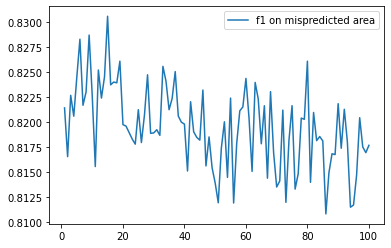

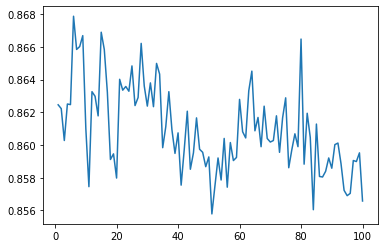

In [18]:
print("Best weight on all is: ", best_weight_all)
print("Best weight on misprediction area is: ", best_weight_mis)
plt.plot(grid_upweights, f1_mispredicted, label = "f1 on mispredicted area")
plt.legend()
plt.show()
plt.plot(grid_upweights, f1_all, label = "f1 on all data")
plt.show()

In [20]:
from helper import get_mispredicted_region_test

weights = generateTrain_data_Weights(BGMD_rules, X_train, upweight_value=best_weight_mis)
c = Counter(weights)
MAPS_model = DecisionTreeClassifier()
scores_MAPS = cross_val_score(MAPS_model, X=X_train, y=y_train, cv = FOLDS)
MAPS_model.fit(X_train, y_train, sample_weight = weights)
y_pred_MAPS = MAPS_model.predict(X_test)
get_performance(X_test, y_test, y_pred_MAPS)

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_default, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='target')

Performance on all data
Precision: 0.8666520053896446
Recall: 0.8641266527487822
F1 Score: 0.8652345612560337
y_actual_MD: 2371
y_predict_default_MD: 2371
y_pred_SMOTE_MD: 2371
y_pred_MAPS_MD: 2371

Default: (0.8160194613235521, 0.8144242935470266, 0.8150696503175854, None)
SMOTE: (0.8034453181560476, 0.7988190636862084, 0.8003226589729502, None)
MAPS: (0.8281486299111392, 0.827498945592577, 0.8277895466031555, None)


In [21]:
dict = {'acc_all': acc_all, 'recall_all': recall_all, 'f1_all': f1_all, 'acc_mispredicted': acc_mispredicted, 'recall_mispredicted': recall_mispredicted, 'f1_mispredicted': f1_mispredicted}
out = pd.DataFrame(dict)
out.to_csv('MAPS_Job_Change_DT.csv')

# Just Train Twice

In [22]:
from helper import generate_JTT_Weights

In [23]:
X_train_1st, X_val, y_train_1st, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 29)

model_JTT = DecisionTreeClassifier()
scores_JTT_1st = cross_val_score(model_JTT, X_train_1st, y=y_train_1st, cv = FOLDS)
model_JTT.fit(X_train_1st, y_train_1st)
y_pred_JTT_val = model_JTT.predict(X_val)
get_performance(X_val, y_val, y_pred_JTT_val)

Performance on all data
Precision: 0.8240690692825178
Recall: 0.8237686398553999
F1 Score: 0.8239171427778788


(0.8240690692825178, 0.8237686398553999, 0.8239171427778788, None)

In [24]:
grid_upweights_JTT = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
best_weight_all_JTT = 1
best_f1_all_JTT = 0
f1_all_JTT = [];

for upweight in grid_upweights_JTT:
    weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = upweight)
    
    #combine train and validate data
    weights = np.concatenate((np.ones(len(X_train_1st)), weights))
    y_train_2nd = np.concatenate((y_train_1st, y_val))
    X_train_2nd = pd.concat([X_train_1st, X_val])
    X_train_2nd['val_weight'] = weights
    X_train_2nd['target'] = y_train_2nd
    X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
    weights = X_train_2nd['val_weight'].to_list()
    y_train_2nd = X_train_2nd['target']
    X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)
    
    model_JTT = DecisionTreeClassifier()
    scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
    model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
    y_pred_JTT = model_JTT.predict(X_test)
    total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)
    f1_all_JTT.append(total_result_JTT[2])
    if total_result_JTT[2] > best_f1_all_JTT:
        best_f1_all_JTT = total_result_JTT[2]
        best_weight_all_JTT = upweight;

Performance on all data
Precision: 0.8613612985405833
Recall: 0.8583855254001391
F1 Score: 0.8596798500215682
Performance on all data
Precision: 0.8625523792633835
Recall: 0.8573416840640222
F1 Score: 0.8594292038396679
Performance on all data
Precision: 0.8613364201191276
Recall: 0.8576896311760612
F1 Score: 0.8592360467640758
Performance on all data
Precision: 0.859736180649191
Recall: 0.8549060542797495
F1 Score: 0.8568797712453755
Performance on all data
Precision: 0.8550433486914631
Recall: 0.8507306889352818
F1 Score: 0.8525428335884817
Performance on all data
Precision: 0.8537515311617629
Recall: 0.8503827418232429
F1 Score: 0.8518476669993466
Performance on all data
Precision: 0.8579881980483695
Recall: 0.8533402922755741
F1 Score: 0.855259095986083
Performance on all data
Precision: 0.8586830833184118
Recall: 0.8536882393876131
F1 Score: 0.8557239223486529
Performance on all data
Precision: 0.8577014176881761
Recall: 0.8528183716075156
F1 Score: 0.8548204873784024
Performance 

JTT Best weight on all is:  10
JTT Best f1 score on all:  0.8596798500215682


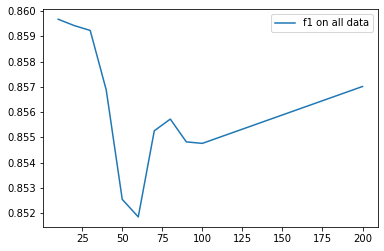

In [25]:
print("JTT Best weight on all is: ", best_weight_all_JTT)
print("JTT Best f1 score on all: ", best_f1_all_JTT)
plt.plot(grid_upweights_JTT, f1_all_JTT, label = "f1 on all data")
plt.legend()
plt.show()

In [26]:
weights = generate_JTT_Weights(y_val.to_list(), y_pred_JTT_val, weight = best_weight_all_JTT)
    
#combine train and validate data
weights = np.concatenate((np.ones(len(X_train_1st)), weights))
y_train_2nd = np.concatenate((y_train_1st, y_val))
X_train_2nd = pd.concat([X_train_1st, X_val])
X_train_2nd['val_weight'] = weights
X_train_2nd['target'] = y_train_2nd
X_train_2nd = X_train_2nd.sample(frac=1, random_state=1).reset_index(drop=True)
weights = X_train_2nd['val_weight'].to_list()
y_train_2nd = X_train_2nd['target']
X_train_2nd = X_train_2nd.drop(['val_weight', 'target'], axis=1)

model_JTT = DecisionTreeClassifier()
scores_JTT_2nd = cross_val_score(model_JTT, X_train_2nd, y=y_train_2nd, cv = FOLDS)
model_JTT.fit(X_train_2nd, y_train_2nd, sample_weight = weights)
y_pred_JTT = model_JTT.predict(X_test)
total_result_JTT = get_performance(X_test, y_test, y_pred_JTT)

default_MD_metric, SMOTE_MD_metric, MAPS_MD_metric = get_mispredicted_region_test(X_test, y_test, y_pred_JTT, y_pred_SMOTE, y_pred_MAPS, BGMD_rules, ylabel='target')

Performance on all data
Precision: 0.8631012668949913
Recall: 0.8599512874043146
F1 Score: 0.8613073665914682
y_actual_MD: 2371
y_predict_default_MD: 2371
y_pred_SMOTE_MD: 2371
y_pred_MAPS_MD: 2371

Default: (0.8181711144640083, 0.8165331083930831, 0.8171897829035751, None)
SMOTE: (0.8034453181560476, 0.7988190636862084, 0.8003226589729502, None)
MAPS: (0.8281486299111392, 0.827498945592577, 0.8277895466031555, None)
